Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Yiyu Gan"
COLLABORATORS = ""

---

# Problem description

In the last assignment, we created fully connected neural networks to
solve the task of classifying whether a ship is present in a satellite photo.

This assignment will address the same task, but using Convolutional Neural Network layers.


## Goal:

In this notebook, you will need to create a model in `TensorFlow/Keras` *using Convolutional layers*  to classify satellite photos. 

- The features are images: 3 dimensional collection of pixels
  - 2 spatial dimensions
  - 1 dimension with 3 features for different parts of the color spectrum: Red, Green, Blue
- The labels are either 1 (ship is present) or 0 (ship is not present)

Unlike the model we created in the previous assignment (using Dense/Fully Connected layers)
we will retain *all three color channels* of the data rather than converting it to one channel gray scale.

There are two notebook files in this assignment:
- The one you are viewing now: First and only notebook you need to work on. 
    - Train your models here
    - There are cells that will save your models to a file
- **`Model_test.ipynb`**:
    - PLEASE IGNORE    


## Learning objectives
- Learn how to construct Neural Networks in a Keras Sequential model that uses Convolutional layer types.
- Appreciate how layer choices impact number of weights

# Import modules

In [2]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline

## Import tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.4.1
Version 2, minor 4


# API for students

We have defined some utility routines in a file `helper.py`. There is a class named `Helper` in it.  

This will simplify problem solving

More importantly: it adds structure to your submission so that it may be easily graded

`helper = helper.Helper()`

- getData: Get a collection of labeled images, used as follows

  >`data, labels = helper.getData()`
- showData: Visualize labelled images, used as follows

  >`helper.showData(data, labels)`
- plot training results: Visualize training accuracy, loss and validation accuracy, loss

  >`helper.plotTrain(history, modelName)`, where history is the result of model training
- save model: save a model in `./models` directory

  >`helper.saveModel(model, modelName)`
- save history: save a model history in `./models` directory
  >`helper.saveHistory(history, modelName)`
 


In [3]:
# Load the helper module
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%reload_ext autoreload
%autoreload 1

# Import nn_helper module
import helper
%aimport helper

helper = helper.Helper()


# Get the data

The first step in our Recipe is Get the Data.

We have provided a utility method `getData` to simplify this for you

In [4]:
# Get the data
data, labels = helper.getData()
n_samples, width, height, channel = data.shape

print("Data shape: ", data.shape)
print("Labels shape: ", labels.shape)
print("Label values: ", np.unique(labels))



Data shape:  (4000, 80, 80, 3)
Labels shape:  (4000,)
Label values:  [0 1]


We will shuffle the examples before doing anything else.

This is usually a good idea
- Many datasets are naturally arranged in a *non-random* order, e.g., examples with the sample label grouped together
- You want to make sure that, when you split the examples into training and test examples, each split has a similar distribution of examples

In [5]:
# Shuffle the data
data, labels = sklearn.utils.shuffle(data, labels, random_state=42)

## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek


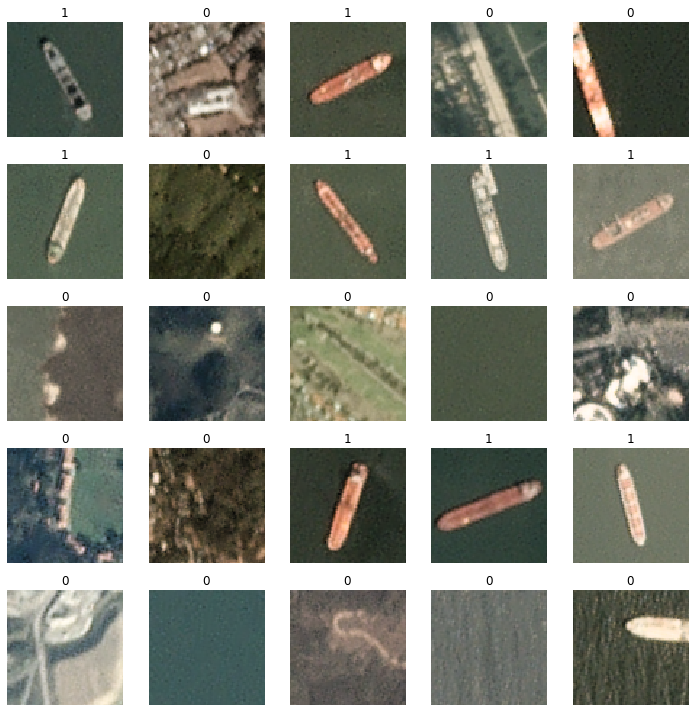

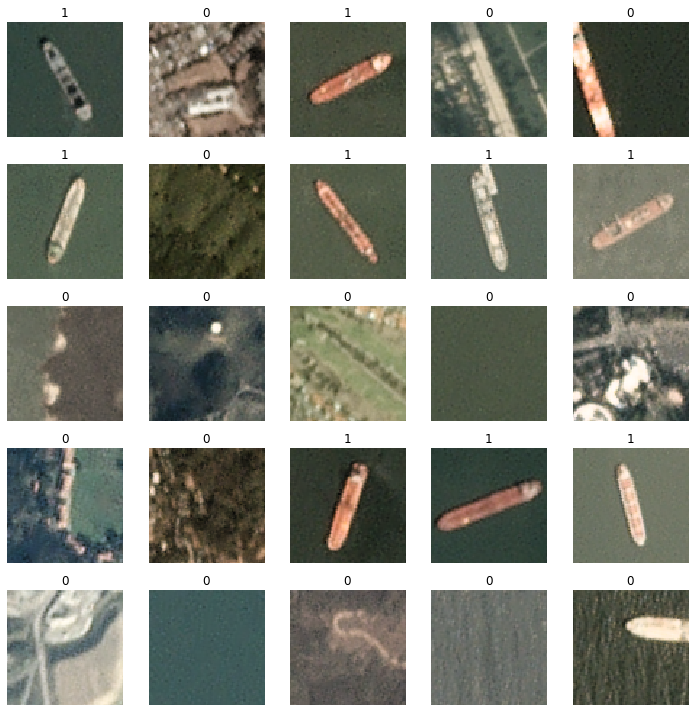

In [6]:
# Visualize the data samples
helper.showData(data[:25], labels[:25])


## Have  look at the data: Examine the image/label pairs

Rather than viewing the examples in random order, let's group them by label.

Perhaps we will learn something about the characteristics of images that contain ships.

We have loaded and shuffled our dataset, now we will take a look at image/label pairs. 

Feel free to explore the data using your own ideas and techniques.


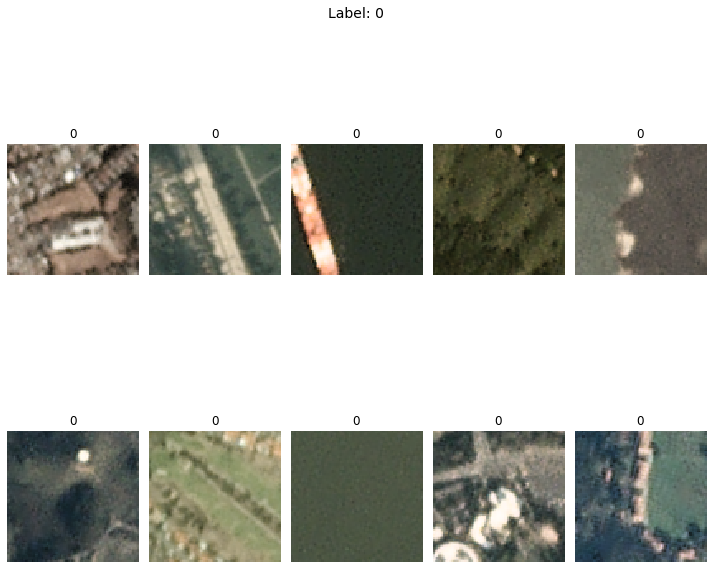

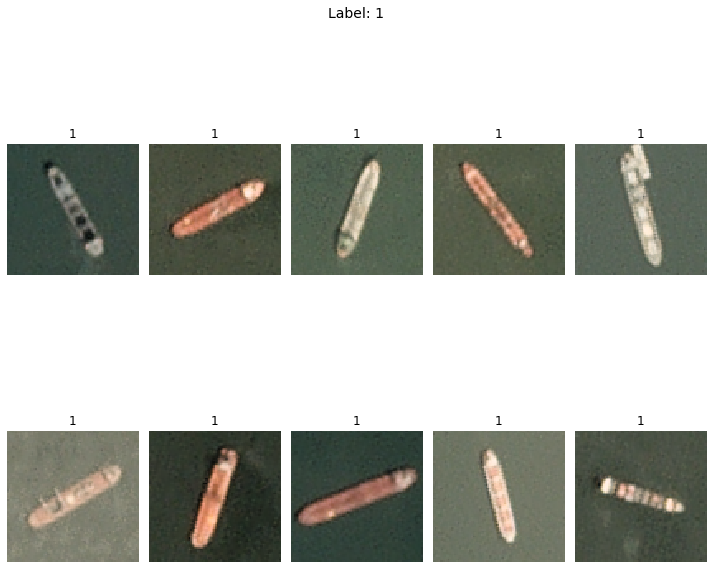

In [7]:
# Inspect some data (images)
num_each_label = 10

for lab in np.unique(labels):
    # Fetch images with different labels
    X_lab, y_lab = data[ labels == lab ], labels[ labels == lab]
    # Display images
    fig = helper.showData( X_lab[:num_each_label], [ str(label) for label in y_lab[:num_each_label] ], cmap="gray")
    _ = fig.suptitle("Label: "+  str(lab), fontsize=14)
    print("\n\n")


# Make sure the features are in the range [0,1]  

**Warm up exercise:** When we want to train on image data, the first thing we usually need to do is scaling. 

Since the feature values in our image data are between 0 and 255, to make them between 0 and 1, we need to divide them by 255.  

We also need to consider how to represent our target values
- If there are more than 2 possible target values, One Hot Encoding may be appropriate
    - **Hint**: Lookup `tf.keras.utils.to_categorical`
- If there are only 2 possible targets with values 0 and 1 we can use these targets without further encoding

**Question**
- Set variable `X` to be our examples (`data`), but with values in the range [0,1]
- Set variable `y` to be the representation of our target values



In [8]:
# Scale the data
# Assign values for X, y
#  X: the array of features
#  y: the array of labels
# The length of X and y should be identical and equal to the length of data.
from tensorflow.keras.utils import to_categorical
X, y = np.array([]), np.array([])

# YOUR CODE HERE
X = data/255
y = labels

In [9]:
# Check if your solution is right 

assert X.shape == (4000, 80, 80, 3)
assert ( (y.shape == (4000,)) or (y.shape == (4000,1)) )


# Split data into training data and testing data
To train and evaluate a model, we need to split the original dataset into
a training subset (in-sample) and a test subset (out of sample).

We will do this for you in the cell below.

**DO NOT** shuffle the data until after we have performed the split into train/test sets
- We want everyone to have the **identical** test set for grading
- Do not change this cell



In [10]:
# Split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Save X_train, X_test, y_train, y_test for final testing
if not os.path.exists('./data'):
    os.mkdir('./data')
np.savez_compressed('./data/train_test_data.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)


# Create a simple CNN model 

**Question:** Create a Keras Sequential model:
- With a single Convolutional Layer providing the number of features given in variable `num_conv_features1` indicated below.
    - You may choose your own kernel size
    - Use full padding (also called "same padding") to make the spatial dimension of the input and output of a convolutional layer identical
- Feeding a head layer implementing Classification  

Please name your Convolutional layer "CNN_1" and your Dense layer (head layer) "dense_head"

Set variable `model0` to be a Keras `Sequential` model object that implements your model.

**Hints:**
1. The `input shape` argument of the first layer should be the shape of a single example, which should be 3-dimensional. We don't need to flatten the data before feeding the Convolutional layer.
2. What is the shape of the output of the Convolutional Layer ? What should be the shape of the input to the Classification head ?
    - You may want to flatten the output of the Convolutional layer before feeding the Classification head.
3. The number of units in your head layer 
    - Depends on how you represented the target
    - It should be equal to the final dimension of  `y`

4. Activation function for the head layer: Since this is a classification problem
    - Use  `sigmoid` if your target's final dimension equals 1
    - Use  `softmax` if your target's final dimension is greater than 1

Think about the number of parameters in this model and whether
it is likely to be prone to overfitting. 
If you feel the need:

- A Dropout layer maybe helpful to prevent overfitting and accelerate your training process. 
    - If you want to use a Dropout layer, you can use `Dropout()`, which is in  `tensorflow.keras.layers`. 



In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# Set model0 equal to a Keras Sequential model
model0 = None

num_conv_features1 = 32

# YOUR CODE HERE
model0 = Sequential([Conv2D(num_conv_features1, kernel_size=(3, 3), 
                            padding='same', input_shape=(80, 80, 3), name='CNN_1'),
                    Dropout(0.2),
                    Flatten(), 
                    Dense(1, activation='sigmoid', name='dense_head')
                    ])

model0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 80, 80, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense_head (Dense)           (None, 1)                 204801    
Total params: 205,697
Trainable params: 205,697
Non-trainable params: 0
_________________________________________________________________


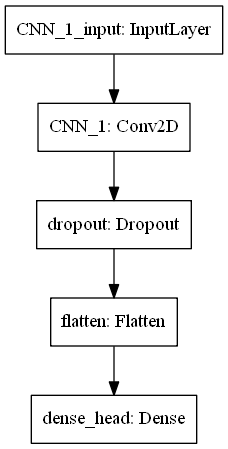

In [12]:
# Plot your model
plot_model(model0)

## Train model


**Question:**

Now that you have built your first model, you will compile and train it. The requirements are as follows:

- Split the **training** examples `X_train, y_train` again !
    - 80% will be used for training the model
    - 20% will be used as validation (out of sample) examples
    - Use `train_test_split()` from `sklearn` to perform this split
        -  Set the `random_state` parameter of `train_test_split()` to be 42

- Loss function: 
    - `binary_crossentropy` if your target is one-dimensional
    - `categorical_crossentropy`if your target is One Hot Encoded
- Metric: "accuracy"
- Use the value in variable `max_epochs` as the number of epochs for training

- Plot your training results using the`plotTrain` method described in the Student API above.


Epoch 1/10
90/90 [==============================] - 11s 122ms/step - loss: 2.5620 - acc: 0.7094 - val_loss: 0.2992 - val_acc: 0.8917
Epoch 2/10
90/90 [==============================] - 11s 118ms/step - loss: 0.3267 - acc: 0.8825 - val_loss: 0.1899 - val_acc: 0.9181
Epoch 3/10
90/90 [==============================] - 11s 117ms/step - loss: 0.2363 - acc: 0.9163 - val_loss: 0.1935 - val_acc: 0.9208
Epoch 4/10
90/90 [==============================] - 10s 117ms/step - loss: 0.2620 - acc: 0.9065 - val_loss: 0.2118 - val_acc: 0.9208
Epoch 5/10
90/90 [==============================] - 10s 116ms/step - loss: 0.1981 - acc: 0.9222 - val_loss: 0.1859 - val_acc: 0.9264
Epoch 6/10
90/90 [==============================] - 11s 118ms/step - loss: 0.1227 - acc: 0.9594 - val_loss: 1.2283 - val_acc: 0.6389
Epoch 7/10
90/90 [==============================] - 10s 117ms/step - loss: 0.1841 - acc: 0.9377 - val_loss: 0.2963 - val_acc: 0.8986
Epoch 8/10
90/90 [==============================] - 10s 116ms/step - 

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002E75ED31808>,
       dtype=object))

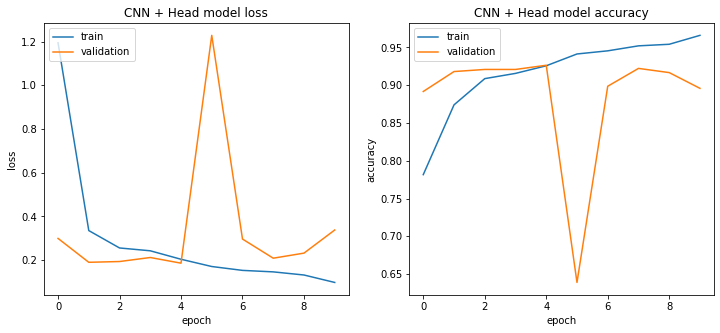

In [13]:
model_name0 = "CNN + Head"
max_epochs = 10

# YOUR CODE HERE
metrics = ["acc"]
X_train1, X_valid, y_train1, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model0.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=metrics)
history0 = model0.fit(X_train1, y_train1,
                     epochs=max_epochs,
                     validation_data=(X_valid, y_valid)
                     )
helper.plotTrain(history0, model_name=model_name0)

## How many weights in the model ?

**Question:** 

Calculate the number of parameters in your model.  

Set variable `num_parameters0` to be equal to the number of parameters in your model.

**Hint:** The model object may have a method to help you ! Remember that Jupyter can help you find the methods that an object implements.



In [14]:
# Set num_parameters2 equal to the number of weights in the model
num_parameters0 = None

# YOUR CODE HERE
num_parameters0 = model0.count_params()

print("Parameters number in model0: ", num_parameters0)

Parameters number in model0:  205697


## Evaluate the model

**Question:**

We have trained our model. We now need to  evaluate the model using the test dataset created in an earlier cell.

Please store the model score in a variable named `score0`.   

**Hint:** The model object has a method  `evaluate`.  Use that to compute the score.




In [15]:
score0 = []

# YOUR CODE HERE
score0 = model0.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name0, l=score0[0], a=score0[1]))

13/13 [==============================] - 0s 14ms/step - loss: 0.3602 - acc: 0.8825
CNN + Head: Test loss: 0.36 / Test accuracy: 0.88


Your test accuracy should be around 0.9

## Save the trained model0 and history for submission

Your fitted model can be saved for later use
- In general: so you can resume training at a later time
- In particular: to allow us to grade it !

Execute the following cell to save your model, which you will submit to us for grading.

In [16]:
helper.saveModel(model0, model_name0)
helper.saveHistory(history0, model_name0)

Directory .\models\CNN + Head already exists, files will be over-written.
Model saved in directory .\models\CNN + Head; create an archive of this directory and submit with your assignment.
Directory .\models\CNN + Head already exists, files will be over-written.


In [17]:
## Restore the model (make sure that it works)
model_loaded = helper.loadModel(model_name0)
score_loaded = model_loaded.evaluate(X_test, y_test, verbose=0)

assert score_loaded[0] == score0[0] and score_loaded[1] == score0[1]

# Create a model with 4 Convolutional layers

**Question:** 

We will now create a model with more Convolutional layers.
- Use **4** Convolutional layers.
    - You may choose your own kernel size
    - Use full padding
    - ReLU activation functions for the Convolutional layers

    - Each of the first two Convolutional layers should have the number of features given in variable `num_conv_features1` indicated below
        - Please name thee layers "CNN_1" and "CNN_2"
    - Each of the last two Convolutional layers should have the number of features given in variable `num_conv_features2` indicated below
        - Please name thee layers "CNN_3" and "CNN_4"
- Insert a `MaxPooling` layer after every two Convolutional layers (e.g., after CNN_2 and CNN_4)
    - to reduce each spatial dimension by a factor of 2  

- Please name your head layer "dense_head". 

Set variable `model1` to be a Keras `Sequential` model object that implements your model.

**Hints:**
- Don't forget to flatten the output of the layer feeding the Classification head 
- A Dropout layer maybe helpful to prevent overfitting and accelerate your training process. 


In [18]:
# Set model1 equal to a Keras Sequential model
model1 = None
num_conv_features1 = 32
num_conv_features2 = 64

# YOUR CODE HERE
model1 = Sequential([Conv2D(num_conv_features1, kernel_size=(3, 3),
                            padding='same', input_shape=(80, 80, 3), 
                            activation='relu', name='CNN_1'),
                     Conv2D(num_conv_features1, kernel_size=(3, 3),
                            padding='same', activation='relu', name='CNN_2'),
                     MaxPooling2D(pool_size=(2, 2)),
                     Conv2D(num_conv_features2, kernel_size=(3, 3),
                            padding='same', activation='relu', name='CNN_3'),
                     Conv2D(num_conv_features2, kernel_size=(3, 3),
                            padding='same', activation='relu', name='CNN_4'),
                     MaxPooling2D(pool_size=(2, 2)),
                     Dropout(0.2),
                     Flatten(),
                     Dense(1, activation='sigmoid', name='dense_head')
                    ])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        896       
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 64)        18496     
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20, 64)       

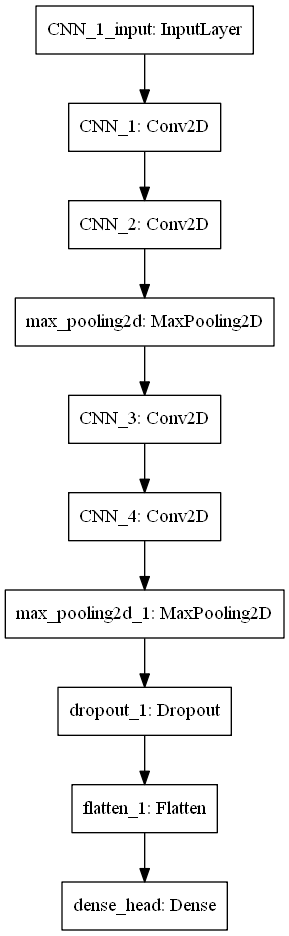

In [19]:
# Plot your model
plot_model(model1)

## Train model

**Question:**

Train your new model following the same instructions as given for training the first model.
- Use the same datasets for training and validation as in your first model
- Use the same Loss function and metrics as in your first model
- **Except**: Save your training results in a variable named `history1`



Epoch 1/10
90/90 [==============================] - 41s 453ms/step - loss: 0.4946 - acc: 0.7598 - val_loss: 0.3192 - val_acc: 0.9083
Epoch 2/10
90/90 [==============================] - 41s 451ms/step - loss: 0.2446 - acc: 0.9071 - val_loss: 0.1499 - val_acc: 0.9375
Epoch 3/10
90/90 [==============================] - 42s 462ms/step - loss: 0.1899 - acc: 0.9287 - val_loss: 0.1464 - val_acc: 0.9472
Epoch 4/10
90/90 [==============================] - 39s 433ms/step - loss: 0.1385 - acc: 0.9501 - val_loss: 0.1096 - val_acc: 0.9639
Epoch 5/10
90/90 [==============================] - 39s 431ms/step - loss: 0.1127 - acc: 0.9602 - val_loss: 0.0778 - val_acc: 0.9736
Epoch 6/10
90/90 [==============================] - 39s 431ms/step - loss: 0.0821 - acc: 0.9714 - val_loss: 0.0818 - val_acc: 0.9722
Epoch 7/10
90/90 [==============================] - 39s 429ms/step - loss: 0.0619 - acc: 0.9821 - val_loss: 0.0681 - val_acc: 0.9764
Epoch 8/10
90/90 [==============================] - 39s 431ms/step - 

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002E75F1FF848>,
       dtype=object))

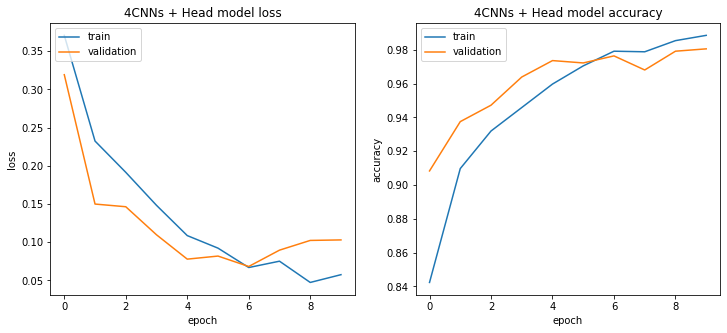

In [20]:
# Train the model using the API
model_name1 = "4CNNs + Head"

# YOUR CODE HERE
max_epochs = 10
metrics = ["acc"]
model1.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=metrics)
history1 = model1.fit(X_train1, y_train1,
                     epochs=max_epochs,
                     validation_data=(X_valid, y_valid)
                     )
helper.plotTrain(history1, model_name=model_name1)

## How many weights in this model ?

**Question:** Calculate the number of parameters in your new model.  

Set variable `num_parameters1` to be equal to the number of parameters in your model.



In [21]:
# Set num_parameters3 equal to the number of weights in the model
num_parameters1 = None

# YOUR CODE HERE
num_parameters1 = model1.count_params()

print('Parameters number in model1:', num_parameters1)

Parameters number in model1: 91169


## Evaluate the model

Evaluate your new model following the same instructions as given for evaluating the first model.
- **Except**: store the model score in a variable named `score1`.  



In [22]:
score1 = []

# YOUR CODE HERE
score1 = model1.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name1, l=score1[0], a=score1[1]))

13/13 [==============================] - 1s 71ms/step - loss: 0.1612 - acc: 0.9700
4CNNs + Head: Test loss: 0.16 / Test accuracy: 0.97


Is your test accuracy higher than before ?

# Save your trained model1 and history1

In [23]:
helper.saveModel(model1, model_name1)
helper.saveHistory(history1, model_name1)

Directory .\models\4CNNs + Head already exists, files will be over-written.
Model saved in directory .\models\4CNNs + Head; create an archive of this directory and submit with your assignment.
Directory .\models\4CNNs + Head already exists, files will be over-written.


## Discussion


You can learn a lot by experimenting.  Some ideas to try:
- Change the kernel size in Convolutional layers
- Change the number of features of Convolutional layers
- Experiment with different pooling layers: `MaxPooling2D` and `AveragePooling2D`
- Change the activation function

Observe the effect of each change on the Loss and Accuracy.

Questions to consider:
- How did the number of parameters change between the two models ?
- How did the choice of layer types affect the number of parameters ?


## Change the kernel size 

Based on the model1, we will change the kernel size from (3,3) to (5,5), others stay the same. Let's see how the change of kernel size will affect the model performance.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        2432      
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 64)        51264     
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 64)        102464    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 20, 64)       

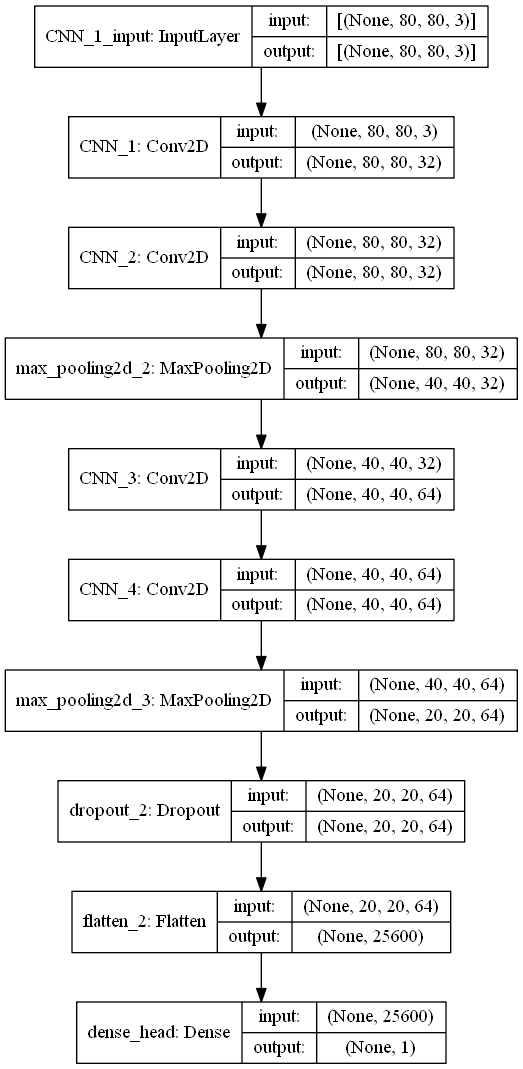

In [24]:
model2 = Sequential([Conv2D(num_conv_features1, kernel_size=(5, 5),
                            padding='same', input_shape=(80, 80, 3), 
                            activation='relu', name='CNN_1'),
                     Conv2D(num_conv_features1, kernel_size=(5, 5),
                            padding='same', activation='relu', name='CNN_2'),
                     MaxPooling2D(pool_size=(2, 2)),
                     Conv2D(num_conv_features2, kernel_size=(5, 5),
                            padding='same', activation='relu', name='CNN_3'),
                     Conv2D(num_conv_features2, kernel_size=(5, 5),
                            padding='same', activation='relu', name='CNN_4'),
                     MaxPooling2D(pool_size=(2, 2)),
                     Dropout(0.2),
                     Flatten(),
                     Dense(1, activation='sigmoid', name='dense_head')
                    ])

model2.summary()
plot_model(model2, show_shapes=True)

Epoch 1/10
90/90 [==============================] - 98s 1s/step - loss: 1.0298 - acc: 0.7662 - val_loss: 0.2837 - val_acc: 0.8792
Epoch 2/10
90/90 [==============================] - 96s 1s/step - loss: 0.3095 - acc: 0.8839 - val_loss: 0.1858 - val_acc: 0.9222
Epoch 3/10
90/90 [==============================] - 97s 1s/step - loss: 0.2526 - acc: 0.9047 - val_loss: 0.2299 - val_acc: 0.9222
Epoch 4/10
90/90 [==============================] - 96s 1s/step - loss: 0.1780 - acc: 0.9321 - val_loss: 0.1231 - val_acc: 0.9486
Epoch 5/10
90/90 [==============================] - 96s 1s/step - loss: 0.1696 - acc: 0.9538 - val_loss: 0.1303 - val_acc: 0.9500
Epoch 6/10
90/90 [==============================] - 96s 1s/step - loss: 0.0991 - acc: 0.9677 - val_loss: 0.0636 - val_acc: 0.9792
Epoch 7/10
90/90 [==============================] - 96s 1s/step - loss: 0.0592 - acc: 0.9783 - val_loss: 0.0579 - val_acc: 0.9806
Epoch 8/10
90/90 [==============================] - 94s 1s/step - loss: 0.0463 - acc: 0.98

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002E75E81A6C8>,
       dtype=object))

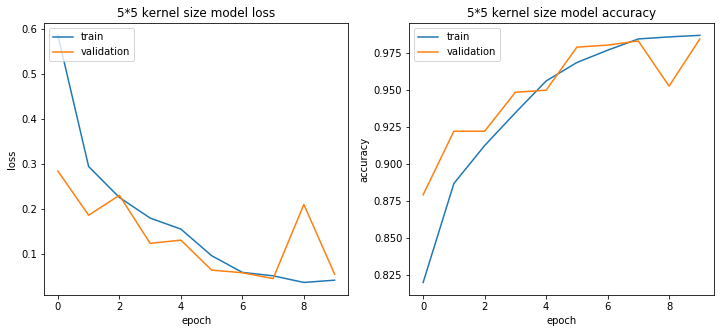

In [25]:
# Train the model using the API
model_name2 = "5*5 kernel size"

max_epochs = 10
metrics = ["acc"]
model2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=metrics)
history2 = model2.fit(X_train1, y_train1,
                     epochs=max_epochs,
                     validation_data=(X_valid, y_valid)
                     )
helper.plotTrain(history2, model_name=model_name2)

In [26]:
num_parameters2 = None
num_parameters2 = model2.count_params()
print('Parameters number in model2:', num_parameters2)

Parameters number in model2: 207393


In [27]:
score2 = []
score2 = model2.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name2, l=score2[0], a=score2[1]))

13/13 [==============================] - 2s 133ms/step - loss: 0.0389 - acc: 0.9875
5*5 kernel size: Test loss: 0.04 / Test accuracy: 0.99


- From the loss and accuracy result, we can easily discover that **both the accuracy and loss improve when we change the kernel size from (3,3) to (5,5)**, the model performance is better.


- Also, with bigger kernel size, the number of parameters will increase. When kernel size changes from (3,3) to (5,5), the number of parameters rises rapidly from 91169 to 207393. At the same time, the running time for model2 is much longer than model1.


- Shown from the figures of model loss and model accuracy above, increasing kernel size also solves part of the overfitting problem in model1. The lines of model2 are more consistent than model1.

Then, we will try to change the kernel size to (1,1). With smaller kernel size, let's see how the model performs.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        128       
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 32)        1056      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 64)        2112      
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 64)        4160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 20, 64)       

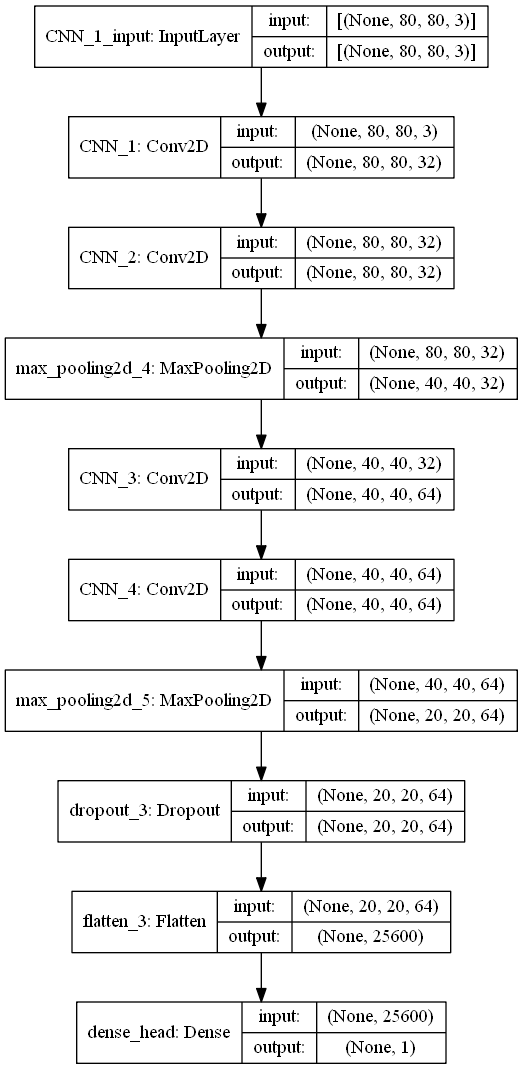

In [28]:
model2 = Sequential([Conv2D(num_conv_features1, kernel_size=(1, 1),
                            padding='same', input_shape=(80, 80, 3), 
                            activation='relu', name='CNN_1'),
                     Conv2D(num_conv_features1, kernel_size=(1, 1),
                            padding='same', activation='relu', name='CNN_2'),
                     MaxPooling2D(pool_size=(2, 2)),
                     Conv2D(num_conv_features2, kernel_size=(1, 1),
                            padding='same', activation='relu', name='CNN_3'),
                     Conv2D(num_conv_features2, kernel_size=(1, 1),
                            padding='same', activation='relu', name='CNN_4'),
                     MaxPooling2D(pool_size=(2, 2)),
                     Dropout(0.2),
                     Flatten(),
                     Dense(1, activation='sigmoid', name='dense_head')
                    ])

model2.summary()
plot_model(model2, show_shapes=True)

Epoch 1/10
90/90 [==============================] - 17s 188ms/step - loss: 0.4885 - acc: 0.7588 - val_loss: 0.1830 - val_acc: 0.9292
Epoch 2/10
90/90 [==============================] - 17s 186ms/step - loss: 0.1970 - acc: 0.9234 - val_loss: 0.1483 - val_acc: 0.9444
Epoch 3/10
90/90 [==============================] - 17s 186ms/step - loss: 0.1738 - acc: 0.9262 - val_loss: 0.1238 - val_acc: 0.9542
Epoch 4/10
90/90 [==============================] - 17s 193ms/step - loss: 0.1377 - acc: 0.9419 - val_loss: 0.1088 - val_acc: 0.9486
Epoch 5/10
90/90 [==============================] - 17s 188ms/step - loss: 0.1426 - acc: 0.9474 - val_loss: 0.1274 - val_acc: 0.9569
Epoch 6/10
90/90 [==============================] - 17s 186ms/step - loss: 0.1268 - acc: 0.9450 - val_loss: 0.1168 - val_acc: 0.9500
Epoch 7/10
90/90 [==============================] - 17s 186ms/step - loss: 0.1130 - acc: 0.9519 - val_loss: 0.1062 - val_acc: 0.9597
Epoch 8/10
90/90 [==============================] - 17s 186ms/step - 

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002E75F403BC8>,
       dtype=object))

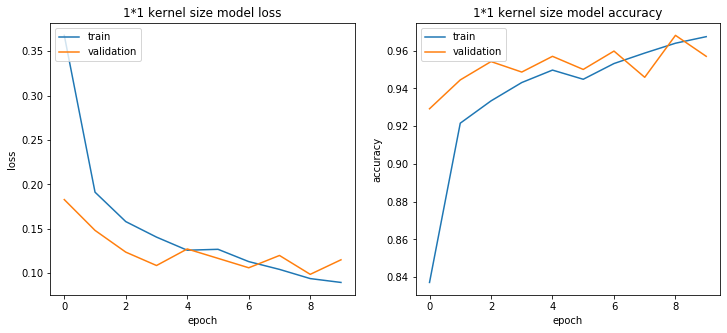

In [29]:
# Train the model using the API
model_name2 = "1*1 kernel size"

max_epochs = 10
metrics = ["acc"]
model2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=metrics)
history2 = model2.fit(X_train1, y_train1,
                     epochs=max_epochs,
                     validation_data=(X_valid, y_valid)
                     )
helper.plotTrain(history2, model_name=model_name2)

In [30]:
num_parameters2 = None
num_parameters2 = model2.count_params()
print('Parameters number in model2:', num_parameters2)

score2 = []
score2 = model2.evaluate(X_test, y_test)
print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name2, l=score2[0], a=score2[1]))

Parameters number in model2: 33057
13/13 [==============================] - 1s 38ms/step - loss: 0.1396 - acc: 0.9450
1*1 kernel size: Test loss: 0.14 / Test accuracy: 0.94


- With smaller kernerl size (1,1), **the parameter number decreased to 33057**. The number of parameters depends on the kernel size. 
- Kernel size also affects the program running time. Smaller kernel size needs less time for each epoch.

The model wit (1,1) kernel size performs well, since the loss and accuracy are good. However, its performance is wrose than other two models with kernel size (3,3) and (5,5). For this model, kernel size (5,5) is the best becasuse of the lowest loss and the highest accuracy. Its accuracy is close to 100%.

## Change the number of features of convolutional features

We will double the size of features to check how the model performance will change. Others will stay the same, kernel size is (3,3) in order to make comparision with model1 better.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        896       
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 64)        18496     
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 20, 64)       

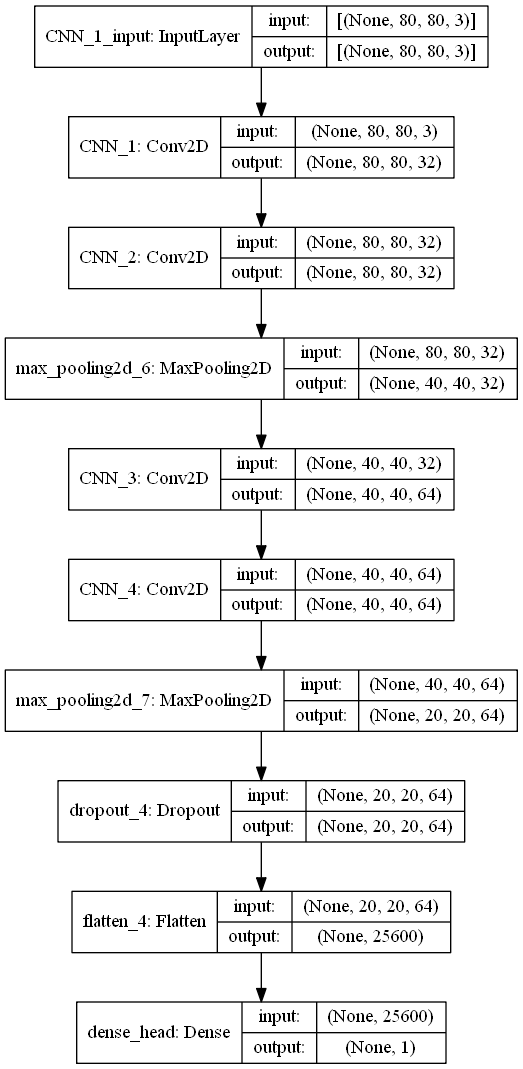

In [31]:
num_cov_features1 = 64
num_cov_features2 = 128
model3 = Sequential([Conv2D(num_conv_features1, kernel_size=(3, 3),
                            padding='same', input_shape=(80, 80, 3), 
                            activation='relu', name='CNN_1'),
                     Conv2D(num_conv_features1, kernel_size=(3, 3),
                            padding='same', activation='relu', name='CNN_2'),
                     MaxPooling2D(pool_size=(2, 2)),
                     Conv2D(num_conv_features2, kernel_size=(3, 3),
                            padding='same', activation='relu', name='CNN_3'),
                     Conv2D(num_conv_features2, kernel_size=(3, 3),
                            padding='same', activation='relu', name='CNN_4'),
                     MaxPooling2D(pool_size=(2, 2)),
                     Dropout(0.2),
                     Flatten(),
                     Dense(1, activation='sigmoid', name='dense_head')
                    ])

model3.summary()
plot_model(model3, show_shapes=True)

Epoch 1/10
90/90 [==============================] - 41s 450ms/step - loss: 0.5715 - acc: 0.7123 - val_loss: 0.3667 - val_acc: 0.8667
Epoch 2/10
90/90 [==============================] - 40s 447ms/step - loss: 0.2816 - acc: 0.8890 - val_loss: 0.2023 - val_acc: 0.9153
Epoch 3/10
90/90 [==============================] - 40s 448ms/step - loss: 0.1945 - acc: 0.9210 - val_loss: 0.1063 - val_acc: 0.9583
Epoch 4/10
90/90 [==============================] - 41s 451ms/step - loss: 0.1537 - acc: 0.9433 - val_loss: 0.1137 - val_acc: 0.9458
Epoch 5/10
90/90 [==============================] - 41s 453ms/step - loss: 0.1300 - acc: 0.9547 - val_loss: 0.1689 - val_acc: 0.9278
Epoch 6/10
90/90 [==============================] - 40s 449ms/step - loss: 0.1029 - acc: 0.9625 - val_loss: 0.0811 - val_acc: 0.9653
Epoch 7/10
90/90 [==============================] - 40s 449ms/step - loss: 0.0696 - acc: 0.9761 - val_loss: 0.1119 - val_acc: 0.9681
Epoch 8/10
90/90 [==============================] - 40s 446ms/step - 

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002E75F717F88>,
       dtype=object))

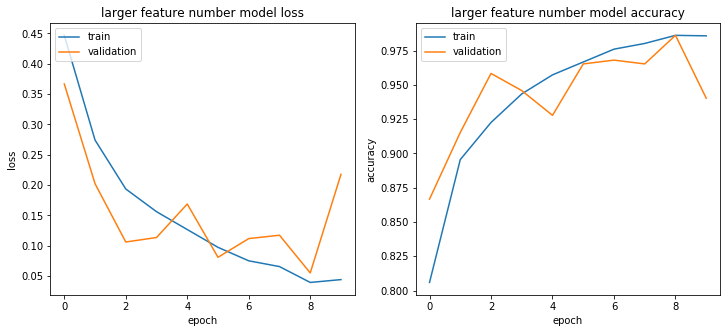

In [32]:
# Train the model using the API
model_name3 = "larger feature number"

max_epochs = 10
metrics = ["acc"]
model3.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=metrics)
history3 = model3.fit(X_train1, y_train1,
                     epochs=max_epochs,
                     validation_data=(X_valid, y_valid)
                     )
helper.plotTrain(history3, model_name=model_name3)

In [33]:
num_parameters3 = None
num_parameters3 = model3.count_params()
print('Parameters number in model3:', num_parameters3)

score3 = []
score3 = model3.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name3, l=score3[0], a=score3[1]))

Parameters number in model3: 91169
13/13 [==============================] - 1s 68ms/step - loss: 0.1605 - acc: 0.9475
larger feature number: Test loss: 0.16 / Test accuracy: 0.95


Doubling the number of features will not change the parameter number of the model. The test and accuracy figures show the **overfitting problem because the feature number increase**. The performance is great just looking at itself. When compared with model1, the loss is similar, but the accuracy is a little bit lower. 

## Different pooling layers

We will experiment with ``AveragePooling2D`` and check the loss and accuracy of model with different pooling layers.

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        896       
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 32)        9248      
_________________________________________________________________
average_pooling2d (AveragePo (None, 40, 40, 32)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 64)        18496     
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 64)        36928     
_________________________________________________________________
average_pooling2d_1 (Average (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 20, 64)       

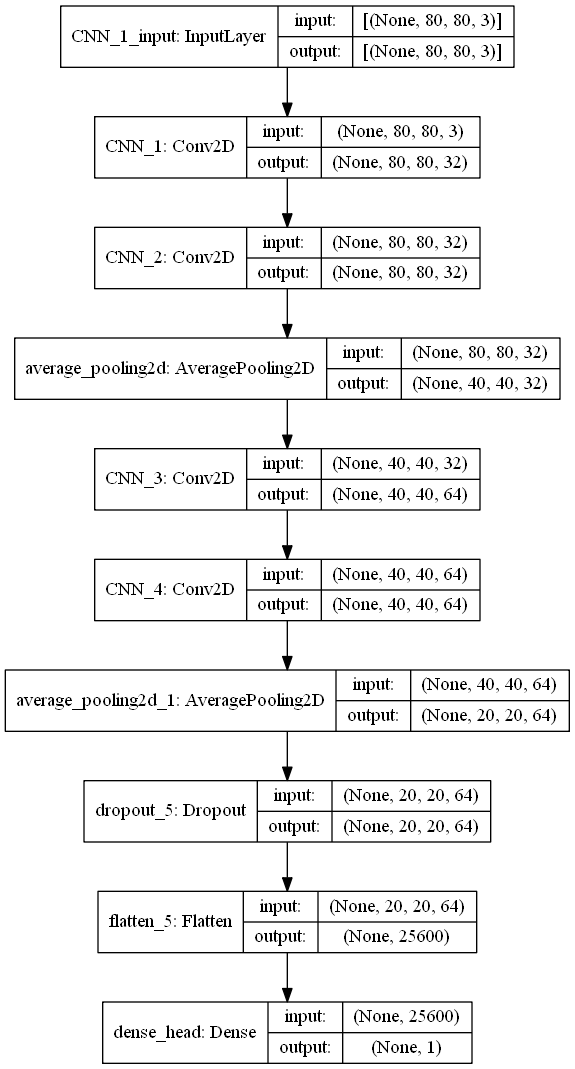

In [34]:
from tensorflow.keras.layers import AveragePooling2D
num_cov_features1 = 32
num_cov_features2 = 64
model4 = Sequential([Conv2D(num_conv_features1, kernel_size=(3, 3),
                            padding='same', input_shape=(80, 80, 3), 
                            activation='relu', name='CNN_1'),
                     Conv2D(num_conv_features1, kernel_size=(3, 3),
                            padding='same', activation='relu', name='CNN_2'),
                     AveragePooling2D(pool_size=(2, 2)),
                     Conv2D(num_conv_features2, kernel_size=(3, 3),
                            padding='same', activation='relu', name='CNN_3'),
                     Conv2D(num_conv_features2, kernel_size=(3, 3),
                            padding='same', activation='relu', name='CNN_4'),
                     AveragePooling2D(pool_size=(2, 2)),
                     Dropout(0.2),
                     Flatten(),
                     Dense(1, activation='sigmoid', name='dense_head')
                    ])

model4.summary()
plot_model(model4, show_shapes=True)

Epoch 1/10
90/90 [==============================] - 39s 429ms/step - loss: 0.5309 - acc: 0.7509 - val_loss: 0.3142 - val_acc: 0.8917
Epoch 2/10
90/90 [==============================] - 39s 437ms/step - loss: 0.2830 - acc: 0.8959 - val_loss: 0.1729 - val_acc: 0.9319
Epoch 3/10
90/90 [==============================] - 40s 439ms/step - loss: 0.2410 - acc: 0.9126 - val_loss: 0.1721 - val_acc: 0.9306
Epoch 4/10
90/90 [==============================] - 39s 435ms/step - loss: 0.1645 - acc: 0.9337 - val_loss: 0.1260 - val_acc: 0.9486
Epoch 5/10
90/90 [==============================] - 39s 438ms/step - loss: 0.1504 - acc: 0.9511 - val_loss: 0.0861 - val_acc: 0.9639
Epoch 6/10
90/90 [==============================] - 39s 432ms/step - loss: 0.1264 - acc: 0.9576 - val_loss: 0.0833 - val_acc: 0.9736
Epoch 7/10
90/90 [==============================] - 39s 433ms/step - loss: 0.0818 - acc: 0.9727 - val_loss: 0.0668 - val_acc: 0.9806
Epoch 8/10
90/90 [==============================] - 39s 435ms/step - 

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002E75F6D0F88>,
       dtype=object))

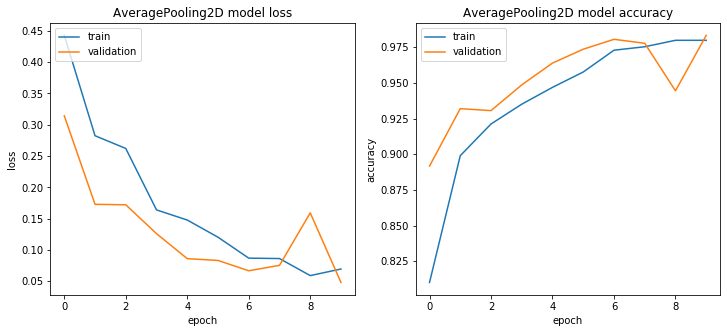

In [35]:
# Train the model using the API
model_name4 = "AveragePooling2D"

max_epochs = 10
metrics = ["acc"]
model4.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=metrics)
history4 = model4.fit(X_train1, y_train1,
                     epochs=max_epochs,
                     validation_data=(X_valid, y_valid)
                     )
helper.plotTrain(history4, model_name=model_name4)

In [36]:
num_parameters4 = None
num_parameters4 = model4.count_params()
print('Parameters number in model4:', num_parameters4)

score4 = []
score4 = model4.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name4, l=score4[0], a=score4[1]))

Parameters number in model4: 91169
13/13 [==============================] - 1s 70ms/step - loss: 0.0831 - acc: 0.9775
AveragePooling2D: Test loss: 0.08 / Test accuracy: 0.98


The pooling layer name expalins itself clearly. ``MaxPooling2D`` measures the maximum, whereas ``AveragePooling2D`` measures the average.

- Changes on pooling layers will not change the number of parameters, which is also 91169.

- For the performance of model with different pooling layers, the test loss is lower than model1, and the accuracy is a liitle bit higher. The figure also shows that this model with averagepooling might have some overfitting problem.

## Change the activation function

We can see how ReLU perfroms from model1. Then, we will change the activation function to **tanh**.

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        896       
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 64)        18496     
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 20, 20, 64)       

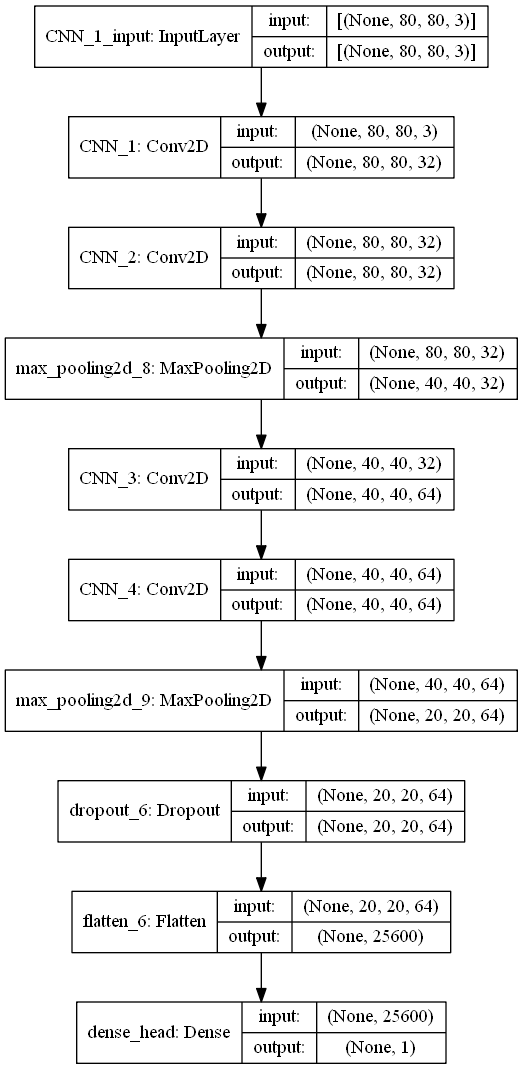

In [37]:
model5 = Sequential([Conv2D(num_conv_features1, kernel_size=(3, 3),
                            padding='same', input_shape=(80, 80, 3), 
                            activation='tanh', name='CNN_1'),
                     Conv2D(num_conv_features1, kernel_size=(3, 3),
                            padding='same', activation='tanh', name='CNN_2'),
                     MaxPooling2D(pool_size=(2, 2)),
                     Conv2D(num_conv_features2, kernel_size=(3, 3),
                            padding='same', activation='tanh', name='CNN_3'),
                     Conv2D(num_conv_features2, kernel_size=(3, 3),
                            padding='same', activation='tanh', name='CNN_4'),
                     MaxPooling2D(pool_size=(2, 2)),
                     Dropout(0.2),
                     Flatten(),
                     Dense(1, activation='sigmoid', name='dense_head')
                    ])

model5.summary()
plot_model(model5, show_shapes=True)

Epoch 1/10
90/90 [==============================] - 43s 470ms/step - loss: 1.0440 - acc: 0.7475 - val_loss: 0.1981 - val_acc: 0.9361
Epoch 2/10
90/90 [==============================] - 42s 464ms/step - loss: 0.2217 - acc: 0.9227 - val_loss: 0.1207 - val_acc: 0.9583
Epoch 3/10
90/90 [==============================] - 42s 466ms/step - loss: 0.1703 - acc: 0.9471 - val_loss: 0.0879 - val_acc: 0.9667
Epoch 4/10
90/90 [==============================] - 42s 468ms/step - loss: 0.1336 - acc: 0.9587 - val_loss: 0.1036 - val_acc: 0.9667
Epoch 5/10
90/90 [==============================] - 42s 467ms/step - loss: 0.1037 - acc: 0.9647 - val_loss: 0.1110 - val_acc: 0.9556
Epoch 6/10
90/90 [==============================] - 42s 471ms/step - loss: 0.0618 - acc: 0.9783 - val_loss: 0.0948 - val_acc: 0.9694
Epoch 7/10
90/90 [==============================] - 42s 465ms/step - loss: 0.0367 - acc: 0.9871 - val_loss: 0.1015 - val_acc: 0.9750
Epoch 8/10
90/90 [==============================] - 42s 467ms/step - 

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002E75FBD4BC8>,
       dtype=object))

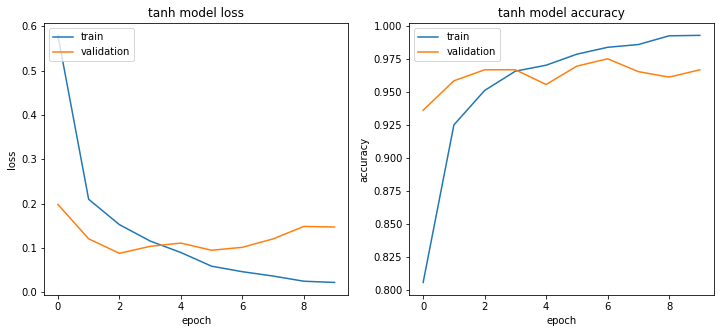

In [38]:
# Train the model using the API
model_name5 = "tanh"

max_epochs = 10
metrics = ["acc"]
model5.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=metrics)
history5 = model5.fit(X_train1, y_train1,
                     epochs=max_epochs,
                     validation_data=(X_valid, y_valid)
                     )
helper.plotTrain(history5, model_name=model_name5)


In [39]:
num_parameters5 = None
num_parameters5 = model5.count_params()
print('Parameters number in model5:', num_parameters5)

score5 = []
score5 = model5.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name5, l=score5[0], a=score5[1]))

Parameters number in model5: 91169
13/13 [==============================] - 1s 77ms/step - loss: 0.1614 - acc: 0.9650
tanh: Test loss: 0.16 / Test accuracy: 0.96


Above is the performance of tanh activation. The parameter number is still 91169. So, we could infer that for the following other activation, the number of parameters should also be the same. 

The model with tanh does not perform very well, because it is obvious that it has the overfitting problem. The test loss is similar to model1. And the accuracy is a liitle bit lower. Compared tanh with ReLU, the latter perfroms better.

Then let's test **sigmoid** activation function.

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        896       
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 40, 40, 32)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 64)        18496     
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 20, 20, 64)       

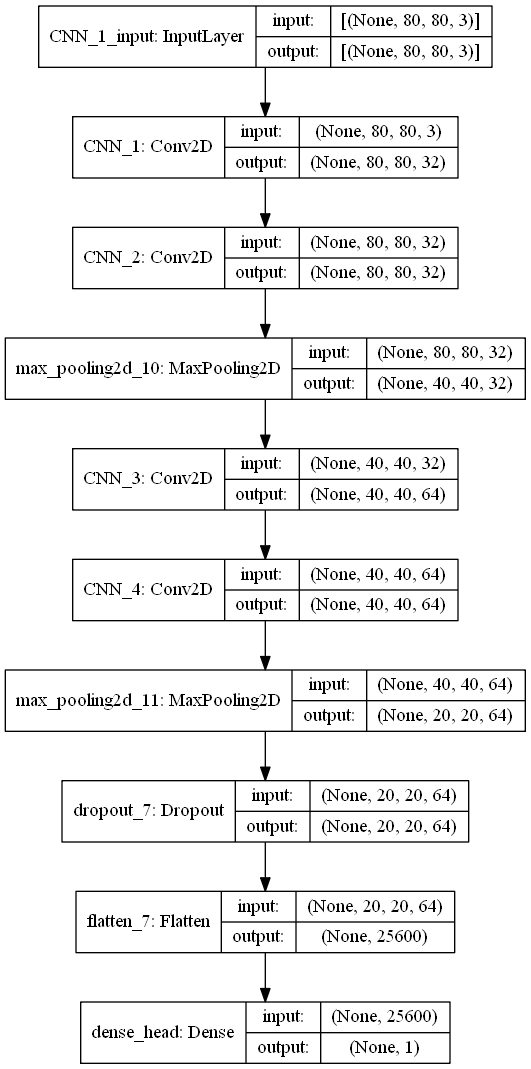

In [40]:
model6 = Sequential([Conv2D(num_conv_features1, kernel_size=(3, 3),
                            padding='same', input_shape=(80, 80, 3), 
                            activation='sigmoid', name='CNN_1'),
                     Conv2D(num_conv_features1, kernel_size=(3, 3),
                            padding='same', activation='sigmoid', name='CNN_2'),
                     MaxPooling2D(pool_size=(2, 2)),
                     Conv2D(num_conv_features2, kernel_size=(3, 3),
                            padding='same', activation='sigmoid', name='CNN_3'),
                     Conv2D(num_conv_features2, kernel_size=(3, 3),
                            padding='same', activation='sigmoid', name='CNN_4'),
                     MaxPooling2D(pool_size=(2, 2)),
                     Dropout(0.2),
                     Flatten(),
                     Dense(1, activation='sigmoid', name='dense_head')
                    ])

model6.summary()
plot_model(model6, show_shapes=True)

Epoch 1/10
90/90 [==============================] - 43s 469ms/step - loss: 1.4004 - acc: 0.7181 - val_loss: 0.6035 - val_acc: 0.7472
Epoch 2/10
90/90 [==============================] - 40s 447ms/step - loss: 0.5783 - acc: 0.7469 - val_loss: 0.5706 - val_acc: 0.7472
Epoch 3/10
90/90 [==============================] - 42s 472ms/step - loss: 0.5736 - acc: 0.7450 - val_loss: 0.5651 - val_acc: 0.7472
Epoch 4/10
90/90 [==============================] - 40s 444ms/step - loss: 0.5641 - acc: 0.7387 - val_loss: 0.5690 - val_acc: 0.7472
Epoch 5/10
90/90 [==============================] - 40s 443ms/step - loss: 0.5493 - acc: 0.7576 - val_loss: 0.3408 - val_acc: 0.8347
Epoch 6/10
90/90 [==============================] - 40s 444ms/step - loss: 0.3449 - acc: 0.8461 - val_loss: 0.2969 - val_acc: 0.8667
Epoch 7/10
90/90 [==============================] - 40s 442ms/step - loss: 0.3679 - acc: 0.8597 - val_loss: 0.2693 - val_acc: 0.8833
Epoch 8/10
90/90 [==============================] - 40s 445ms/step - 

(<Figure size 864x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002E75FFDFA08>,
       dtype=object))

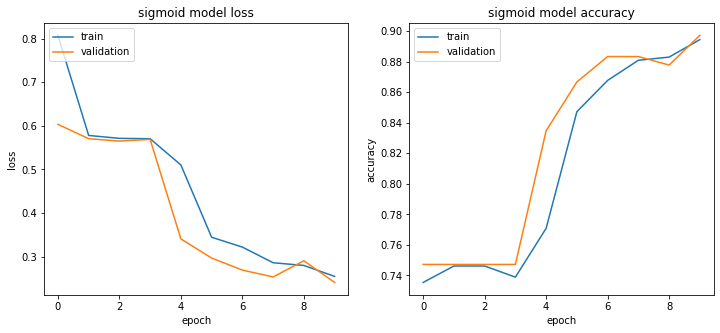

In [41]:
# Train the model using the API
model_name6 = "sigmoid"

max_epochs = 10
metrics = ["acc"]
model6.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=metrics)
history6 = model6.fit(X_train1, y_train1,
                     epochs=max_epochs,
                     validation_data=(X_valid, y_valid)
                     )
helper.plotTrain(history6, model_name=model_name6)


In [42]:
num_parameters6 = None
num_parameters6 = model6.count_params()
print('Parameters number in model6:', num_parameters6)

score6 = []
score6 = model6.evaluate(X_test, y_test)

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name6, l=score6[0], a=score6[1]))

Parameters number in model6: 91169
13/13 [==============================] - 1s 78ms/step - loss: 0.2405 - acc: 0.9000
sigmoid: Test loss: 0.24 / Test accuracy: 0.90


As we expected, the number of parameters does not change. 

The performance of sigmoid is even worse than tanh. The test loss is the highest among all the models that we have experimented, and the test accuray is lowest. Other models have accuracy rate above 0.95, but this model is only around 0.9. However, the lines of training set and validation set seem consistent than other two activation functions. 

Thus, ReLu performs the best in this dataset.

**In Conclusion**

- Based on above few experiments, changing kernel size will change the parameter number. The larger the kernel size, the bigger the number of parameters. Changes on the number of features of convolutional layers, pooling layers, and the activation function will not affect the number of parameters.


-  larger kernel size could improve the performance of the model, but might bring the overfitting problem. Same as larger number of features of Convolutional layers. Maxpooling2D works better for this dataset than AveragePooling2D. The ReLU activation function performs best in this dataset.


- Among all the models we have experimented, model with kernel size (5,5) has the best perfromance. Test loss is 0.04, and test accuracy is 0.99. Both metrics are the best.